In [8]:
from openturns.usecases import ishigami_function
import openturns as ot
from operator import itemgetter

import pylab as pl
import openturns.viewer
import openturns.viewer as viewer

import pandas as pd

from matplotlib import pylab as plt

MODEL + INPUT DISTRIBUTION

In [9]:
def read_data(file):
    """
    Read data resulting from multiple simulations
    """
    
    df = pd.read_csv(file, sep = ';')
    df = df.astype(float)
    df = df.dropna(axis = 0)

    try : 
        df['convergence'] = (- df['tunnel_up'] - df['tunnel_side'] + df['tunnel_down'])/3
    except :
        print('tunnel convergence can not be processed')
    
    return(df)

def train_set(df, cols_x, col_z):
    """
    Extract database to train the surrogate model
    """
    
    xi = df[cols_x].to_numpy()
    zi = df[col_z].to_numpy().reshape(1, -1)[0]

    return(xi, zi)

In [10]:
# EXEMPLE PYTHON SIMULATOR

X0 = ot.Normal(0.0, 1.0)
X1 = ot.Normal(0.0, 1.0)
X2 = ot.Normal(0.0, 1.0)
inputDistribution = ot.ComposedDistribution((X0, X1, X2))

def mySimulator(x):
    y0 = x[0] + x[1] + x[2]
    y1 = x[0] - x[1] * x[2]
    y = [y0, y1]
    return y

n_input, n_output = 3, 2

myfunction = ot.PythonFunction(n_input, n_output, mySimulator)


In [11]:
# EXMPLE ANALYTICAL MODEL

dimension = 8
input_names = ["rw", "r", "Tu", "Hu", "Tl", "Hl", "L", "Kw"]

model = ot.SymbolicFunction(
    input_names, ["(2*pi_*Tu*(Hu-Hl))/(ln(r/rw)*(1+(2*L*Tu)/(ln(r/rw)*rw^2*Kw)+Tu/Tl))"]
)

coll = [
    ot.Normal(0.1, 0.0161812),
    ot.LogNormal(7.71, 1.0056),
    ot.Uniform(63070.0, 115600.0),
    ot.Uniform(990.0, 1110.0),
    ot.Uniform(63.1, 116.0),
    ot.Uniform(700.0, 820.0),
    ot.Uniform(1120.0, 1680.0),
    ot.Uniform(9855.0, 12045.0),
]

distribution = ot.ComposedDistribution(coll)
distribution.setDescription(input_names)

# FREEZE PARAMETERS

selection = [1, 2, 4]
complement = ot.Indices(selection).complement(dimension)
distribution = distribution.getMarginal(complement)

model = ot.ParametricFunction(
    model, selection, distribution.getMarginal(selection).getMean()
)

input_names_copy = list(input_names)
input_names = itemgetter(*complement)(input_names)
dimension = len(complement)

print(dimension)

5


Sobol’ sensitivity indices

In [12]:
def plotXvsY(sampleX, sampleY, figsize = (15, 3)):
    
    dimX = sampleX.getDimension()
    inputdescr = sampleX.getDescription()
    fig = pl.figure(figsize = figsize)
    
    for i in range(dimX):
        ax = fig.add_subplot(1, dimX, i + 1)
        graph = ot.Graph("", inputdescr[i], "Y", True, "")
        cloud = ot.Cloud(sampleX[:, i], sampleY)
        graph.add(cloud)
        _ = ot.viewer.View(graph, figure=fig, axes=[ax])
    
    return(fig)

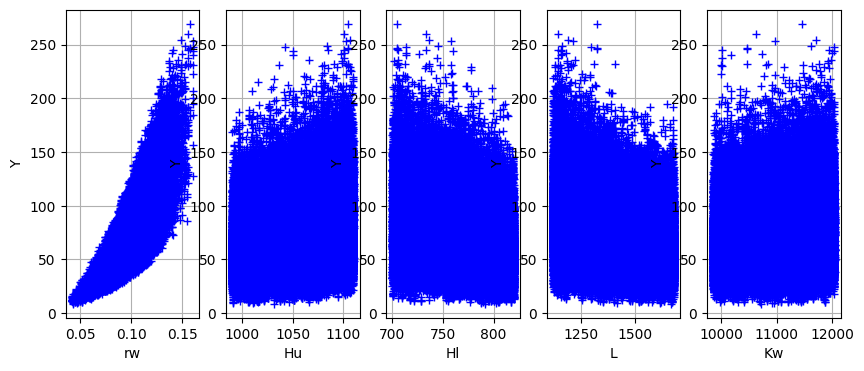

120000

In [13]:
# DESIGN OF EXPERIMENT
# INPUT SOBOL sensitivity indices

n = 10000
computeSecondOrder = True

sie = ot.SobolIndicesExperiment(distribution, n, computeSecondOrder)

sampleX = sie.generate()
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
pl.show()

sampleX.getSize()

In [24]:
# INPUT SOBOL sensitivity indices

path = 'C:/Users/bkratz/OneDrive - SOCOTEC S.A/these/Scripts/dev_ef_model/surrogate_model/input/'
file_name = '2D_database_1step_200.csv'
file_input = path + file_name

cols_x = ['pressure_lckd', 'grad_pressure_lckd', 'surface_weight', 'z_tunnel', 'E_geol_0', 'E_geol_1', 'E_geol_2', 'E_geol_3', 'E_geol_4', 'E_geol_5', 'K0x_0', 'K0x_1', 'K0x_2', 'K0x_3', 'K0x_4', 'K0x_5', 'h_geol_0', 'h_geol_1', 'h_geol_2', 'h_geol_3', 'h_geol_4']
# col_z = ['S_max_peck', 'i_peck', 'tunnel_up', 'tunnel_down', 'tunnel_side', 'max_settlements', 'convergence']
# convergence = - tunnel_up - tunnel_side + tunnel_down
# 0.0 <= convergence <= (overexcavation + conicity + offset)*2
col_z = ['convergence']

df_sample = read_data(file_input)
sampleX, sampleY = train_set(df_sample, cols_x, col_z)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
pl.show()

sampleX.getSize()

AttributeError: 'numpy.ndarray' object has no attribute 'getDimension'

---------------------
First order indices :
[0.655253,0.0822676,0.0730429,0.0720643,0.0052721]

---------------------
Hu & rw : 0.02580830450590954
Hl & rw : 0.020190856836401316
Hl & Hu : 0.026246352017010116
L & rw : 0.03204486357173131
L & Hu : 0.019718930771780496
L & Hl : 0.048527270232073205
Kw & rw : 0.020045977509501878
Kw & Hu : 0.02218368592945151
Kw & Hl : 0.0485713967094724
Kw & L : 0.036652372919841344

---------------------
First order indices :
[0.691775,0.101212,0.117787,0.108536,0.030941]


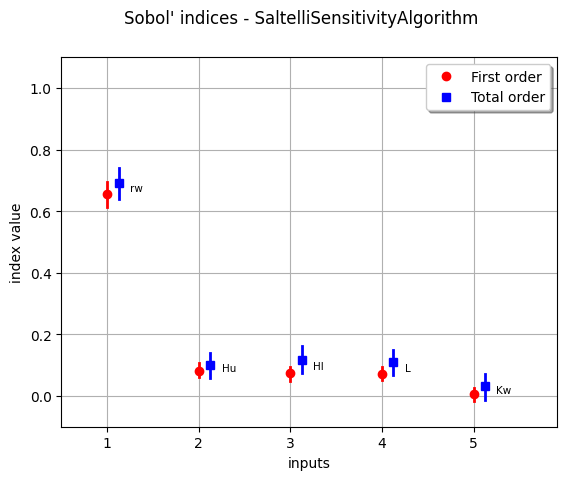

In [15]:
# SOBOL SENSITIVITY ANALYSIS (First, Second and Total order)

print_result = True
plot_result = True

sensitivityAnalysis = ot.SaltelliSensitivityAlgorithm(sampleX, sampleY, n)
#sensitivityAnalysis = MartinezSensitivityAlgorithm(inputDesign, outputDesign, n)
#sensitivityAnalysis = JansenSensitivityAlgorithm(inputDesign, outputDesign, n)
#sensitivityAnalysis = MauntzKucherenkoSensitivityAlgorithm(inputDesign, outputDesign, n)

fo = sensitivityAnalysis.getFirstOrderIndices()
to = sensitivityAnalysis.getTotalOrderIndices()

if computeSecondOrder:
    so = sensitivityAnalysis.getSecondOrderIndices()

print_result = True
plot_result = True

if print_result:
    print('---------------------')
    print('First order indices :')
    print(fo)

    if computeSecondOrder:
        print()
        print('---------------------')
        for i in range(dimension):
                for j in range(i):
                    print(
                        input_names[i] + " & " + input_names[j],
                         ":",
                        so[i, j],
                        )
    print()
    print('---------------------')
    print('First order indices :')
    print(to)

if plot_result:
    graph = sensitivityAnalysis.draw()
    view = viewer.View(graph)
    pl.show()

# We saw that total order indices are close to first order, so the higher order indices must be all quite close to 0


Sobol’ sensitivity indices from chaos

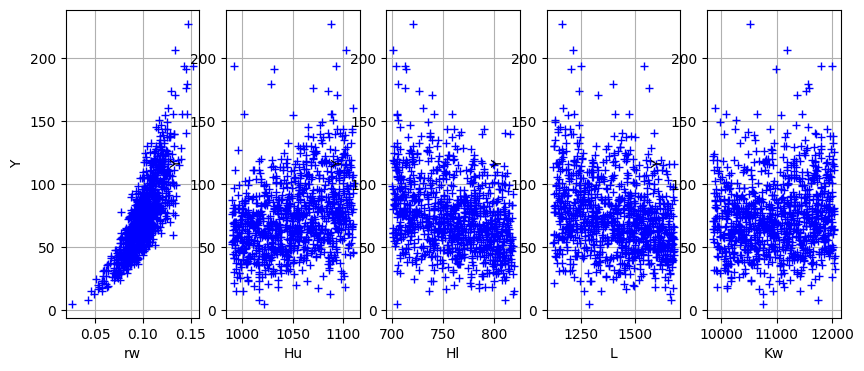

In [16]:
# DESIGN OF EXPERIMENT
# INPUT SOBOL SENSITIVITY ANALYSIS FROM CHAOS 

n = 1000

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
pl.show()

In [17]:
# SOBOL SENSITIVITY ANALYSIS FROM CHAOS (First, Second and Total order)

algo = ot.FunctionalChaosAlgorithm(sampleX, sampleY)
algo.run()
result = algo.getResult()

print(result.getResiduals())
print(result.getRelativeErrors())

[0.00302959]
[1.06763e-05]


---------------------
First order indices :
[0.9914537387850292, 0.002205803322864808, 0.0026983480758455726, 0.0021621581999296995, 0.0005637266524670293]

---------------------
Hu & rw : 0.00023516139084043397
Hl & rw : 0.0002788106544735237
Hl & Hu : 6.059960758921526e-07
L & rw : 0.00024216226158501887
L & Hu : 2.8040040461501123e-05
L & Hl : 3.458291626383193e-05
Kw & rw : 6.407346602069395e-05
Kw & Hu : 7.003463299496848e-06
Kw & Hl : 8.679953755969715e-06
Kw & L : 8.024521596893601e-06

---------------------
First order indices :
[0.992282792157191, 0.0024801508838722033, 0.003025924716715291, 0.002482440503342174, 0.0006539970022346158]


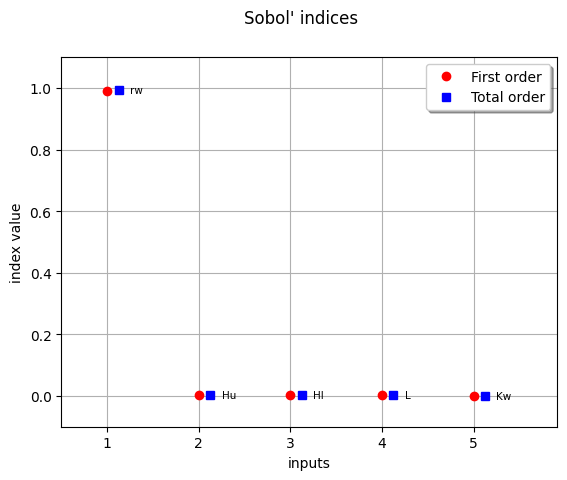

In [18]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)

fo = [sensitivityAnalysis.getSobolIndex(i) for i in range(dimension)]
to = [sensitivityAnalysis.getSobolTotalIndex(i) for i in range(dimension)]

print_result = True
plot_result = True

if print_result:
    print('---------------------')
    print('First order indices :')
    print(fo)

    if computeSecondOrder:
        print()
        print('---------------------')
        for i in range(dimension):
                for j in range(i):
                    print(
                        input_names[i] + " & " + input_names[j],
                         ":",
                        sensitivityAnalysis.getSobolIndex([i, j]),
                        )
    print()
    print('---------------------')
    print('First order indices :')
    print(to)

if plot_result:
    graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, fo, to)
    view = viewer.View(graph)

# We saw that total order indices are close to first order, so the higher order indices must be all quite close to 0


Parallel coordinates graph as sensitivity tool

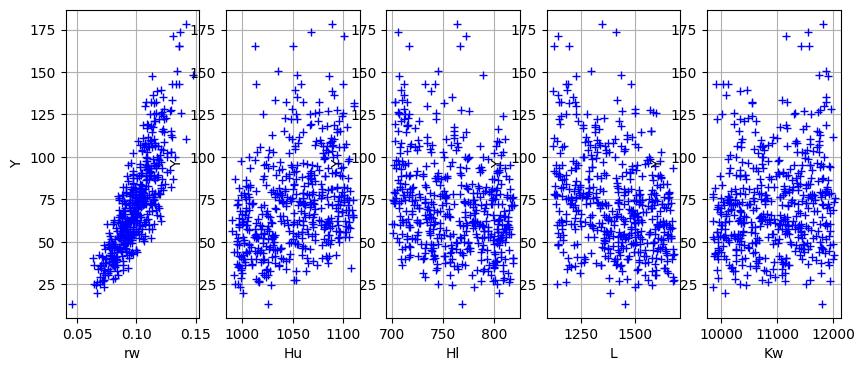

In [19]:
# DESIGN OF EXPERIMENT
# Parallel coordinates graph

n = 500

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
pl.show()

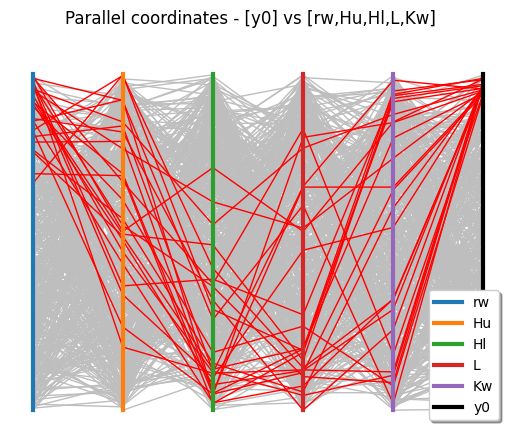

In [20]:
# Value based scale to describe the Y range

minValue = 125
maxValue = 150
quantileScale = False
graphCobweb = ot.VisualTest.DrawParallelCoordinates(
    sampleX, sampleY, minValue, maxValue, "red", quantileScale
)
graphCobweb.setLegendPosition("bottomright")
view = viewer.View(graphCobweb)

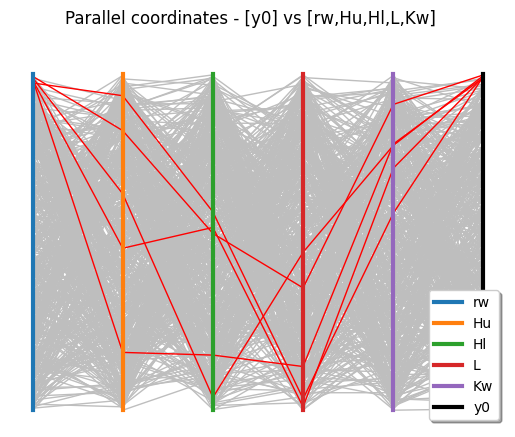

In [21]:
# Rank based scale to describe the Y range

minValue = 0.99
maxValue = 1.0
quantileScale = True
graphCobweb = ot.VisualTest.DrawParallelCoordinates(
    sampleX, sampleY, minValue, maxValue, "red", quantileScale
)
graphCobweb.setLegendPosition("bottomright")
view = viewer.View(graphCobweb)
plt.show()

The HSIC (Hilbert-Schmidt Indepencence Criterion) sensitivity indices

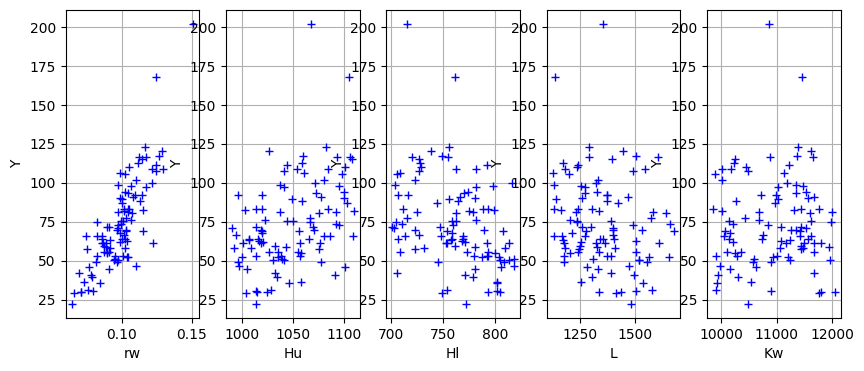

In [22]:
# DESIGN OF EXPERIMENT
# HSIC (Hilbert-Schmidt Indepencence Criterion) sensitivity indices

n = 100

sampleX = distribution.getSample(n)
sampleY = model(sampleX)

fig_test = plotXvsY(sampleX, sampleY, figsize=(10, 4))
pl.show()

In [23]:
# Setting the covariance models
# Here we choose a SquaredExponential kernel for all input variables

# They are all stored in a list of d+1 covariance kernels where d is the number of input variables. The remaining one is for the output variable.

covarianceModelCollection = []

for i in range(dimension):
    Xi = sampleX.getMarginal(i)
    inputCovariance = ot.SquaredExponential(1) # Edit if this is not the good covariance function
    inputCovariance.setScale(Xi.computeStandardDeviation())
    covarianceModelCollection.append(inputCovariance)

# Likewise we define a covariance kernel associated to the output variable.

outputCovariance = ot.SquaredExponential(1)
outputCovariance.setScale(sampleY.computeStandardDeviation())
covarianceModelCollection.append(outputCovariance)